<h1>Credit risk modeling</h1>

<h1> Introduction </h1>
<p> The aim of this paper is to present models for the prediction of the probability of default. The work includes a causal analysis using the following models: Logit and probit, additionally, for predictive purposes, the Random Forest and XGBoost models were also used.
<p>

<h1> Dataset description </h1>

<p>
For the study, I used the dataset from the Kaggle.com platform. The unclean base contained 13,444 observations, for 14 variables describing the sample of customers with credit cards.


The response variable is <b> DEFAULT </b>, which takes the value 1 if the client ever fails, and 0 otherwise.

The other variables are:
<ul>
<li> CARDHLDR - takes the value 1 if the client had an approved credit card application and 0 otherwise </li>
<li> AGE - exact age expressed in years and fractions of years </li>
<li> ACADMOS - months of residence at permanent address </li>
<li> ADEPCNT - 1 + dependents </li>
<li> MAJORDRG - Number of reports of serious violations </li>
<li> MINORDRG - Number of minor violations reports </li>
<li> OWNRENT - the variable takes the value 1 if the client owns his house / flat and 0 if the client rents out </li>
<li> INCOME - monthly income divided by 10,000 </li>
<li> SELFEMPL - the variable takes the value 1 if the client runs his own business, 0 otherwise </li>
<li> INCPER - Income divided by the number of dependents </li>
<li> EXP_INC - credit card spend to income ratio </li>
<li> SPENDING - average monthly credit card expenses </li>
<li> LOGSPEND - logarithm of monthly average credit card spend </li>
</ul>

The database after removing the deficiencies, the variable concerning the acceptance of the card application and the values ​​not very reliable for age, consists of 10,461 observations. Out of the surveyed clients, 9.5% had problems with repayment of the loan. The average age of clients is less than 34 years. On the other hand, 3/4 of the respondents are under the age of 40. The variable has a right-hand asymmetric distribution. We removed outliers due to age, i.e. people who were less than 18 years old in the database. On average, the respondents lived for about 56 months during one period and had 1 dependent. There are few people in the database with serious flaws. The largest number of clients had 6 serious deficiencies, while on average there were 0.14 deficiencies per person in the entire sample. The number of minor deficiencies is similar to the serious deficiencies. This variable assumed the maximum value of 7. Out of all respondents, 47% have their own apartment. The research sample is characterized by a large spread in terms of income. The smallest amount of earnings in the sample is 500,000, while the highest is 83,332,500. 75% of the respondents earn less than 30,416,666. Only 5% of the respondents run their own business. Income divided by the number of dependents is on average 22,577 per month. Credit card spending averages 9% of income. The age, time of living at one address, income and expenditure variables are right-handed, with a significant number of outliers.
<p>

In [ ]:
#import libraries
import pandas as pd
import numpy as np
from scipy.stats import kendalltau, chi2_contingency
import scipy
from statsmodels.discrete.discrete_model import Logit, Probit 
from statsmodels.iolib.summary2 import summary_col
from funkcje import build_model, calculate_woe_iv, Cramer, gini
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import random

In [ ]:
#reading data (without the CARDHLDR variable, because it has only one unique variable)
df = pd.read_csv('credit_data.csv').drop(columns='CARDHLDR')

In [ ]:
#to get rid of spending shortcomings, which are a space, to change SPENDING and LOGSPEND to still
df = df.loc[df['SPENDING']!=' ']
df.rename(columns={'LOGSPEND ':'LOGSPEND'}, inplace=True)
df['SPENDING'] = df['SPENDING'].astype(float)
df['LOGSPEND'] = df['LOGSPEND'].astype(float)
df['AGE'] = df['AGE'].astype(int)
df['ACADMOS'] = df['ACADMOS'].astype(int)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DEFAULT,10499.0,0.094866,0.293044,0.000000,0.000000,0.000000,0.000000,1.000000
AGE,10499.0,33.227831,10.293118,0.000000,25.000000,31.000000,39.000000,88.000000
ACADMOS,10499.0,55.904181,64.127434,0.000000,12.000000,30.000000,72.000000,564.000000
ADEPCNT,10499.0,0.990380,1.273887,0.000000,0.000000,0.000000,2.000000,9.000000
MAJORDRG,10499.0,0.143252,0.461568,0.000000,0.000000,0.000000,0.000000,6.000000
MINORDRG,10499.0,0.220688,0.637142,0.000000,0.000000,0.000000,0.000000,7.000000
OWNRENT,10499.0,0.479093,0.499587,0.000000,0.000000,0.000000,1.000000,1.000000
INCOME,10499.0,2606.125933,1287.983386,50.000000,1750.000000,2291.666667,3041.666667,8333.250000
SELFEMPL,10499.0,0.053624,0.225285,0.000000,0.000000,0.000000,0.000000,1.000000
INCPER,10499.0,22581.362368,13754.973409,700.000000,12900.000000,20000.000000,28336.666992,150000.000000


The lowest age is 0 years, in this case it was removed for people under 18 years of age. The above table proves that we are dealing with a right-hand distribution. The differences in values between the first and second quartiles are less than smaller between the third in the maximum quartile. What do we have for a base of a person with 9 people who uses a person who lives under one person number 47 years old, and there are 166 times more points to score than the person running. However, it is possible that it is possible that employees are due to results that are not due to situations where we have data to clear the day.

In [ ]:
#removal under 18 years of age
df = df.loc[df['AGE']>=18]

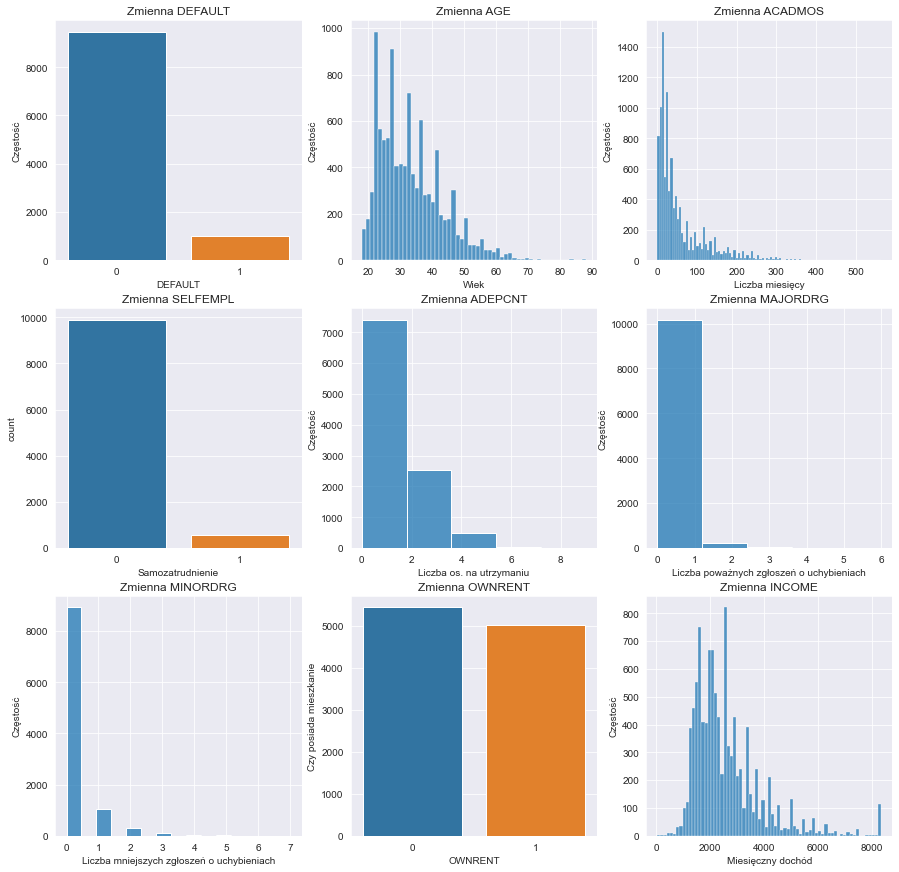

In [ ]:
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)



fig, ax =plt.subplots(3,3)
sns.countplot(df['DEFAULT'], ax=ax[0,0]).set(title='Zmienna DEFAULT', ylabel='Częstość')
sns.histplot(df['AGE'], ax=ax[0,1]).set(title='Zmienna AGE', ylabel='Częstość', xlabel='Wiek')
sns.histplot(df['ACADMOS'], ax=ax[0,2]).set(title='Zmienna ACADMOS', ylabel='Częstość', xlabel='Liczba miesięcy')
sns.countplot(df['SELFEMPL'], ax=ax[1,0]).set(title='Zmienna SELFEMPL', xlabel='Samozatrudnienie')
sns.histplot(df['ADEPCNT'], ax=ax[1,1], bins=5).set(title='Zmienna ADEPCNT', ylabel='Częstość', xlabel='Liczba os. na utrzymaniu')
sns.histplot(df['MAJORDRG'], ax=ax[1,2], bins=5).set(title='Zmienna MAJORDRG', ylabel='Częstość', xlabel='Liczba poważnych zgłoszeń o uchybieniach')
sns.histplot(df['MINORDRG'], ax=ax[2,0]).set(title='Zmienna MINORDRG', ylabel='Częstość', xlabel='Liczba mniejszych zgłoszeń o uchybieniach')
sns.countplot(df['OWNRENT'], ax=ax[2,1]).set(title='Zmienna OWNRENT', ylabel='Czy posiada mieszkanie')
sns.histplot(df['INCOME'], ax=ax[2,2]).set(title='Zmienna INCOME', ylabel='Częstość', xlabel='Miesięczny dochód')


fig.show()


Summing up, our database consists of a small number of people who have reported default, the clients are young, they do not have many dependents, most of them have low or medium earnings, half of them have their own apartment, a small part of the respondents conduct their business. Most clients are between 23 and 27 years old. On average, the respondents live at one address for a little over 4 years, but there are also few people who live at one address for around 30 years. After removing people under 18 from the database, observations with high number of dependents also disappeared, the maximum number of serious breaches is now 2, and the maximum length of a flat at one address fell by 17 years, which confirms that the removal of these observations was the right decision.

In [ ]:
gini_scores=[]
for variable in df.columns:
    gini_scores.append([variable, gini(df[variable])])
pd.DataFrame(gini_scores, columns = ['Zmienna', 'Score'])

,Zmienna,Score
0,DEFAULT,0.905076
1,AGE,0.165289
2,ACADMOS,0.551789
3,ADEPCNT,0.651048
4,MAJORDRG,0.912760
5,MINORDRG,0.891041
6,OWNRENT,0.520409
7,INCOME,0.248771
8,SELFEMPL,0.946277
9,INCPER,0.311323


All of the variables have the appropriate discriminant ability. The lowest value is the "LOGSPEND" and "AGE" variables.

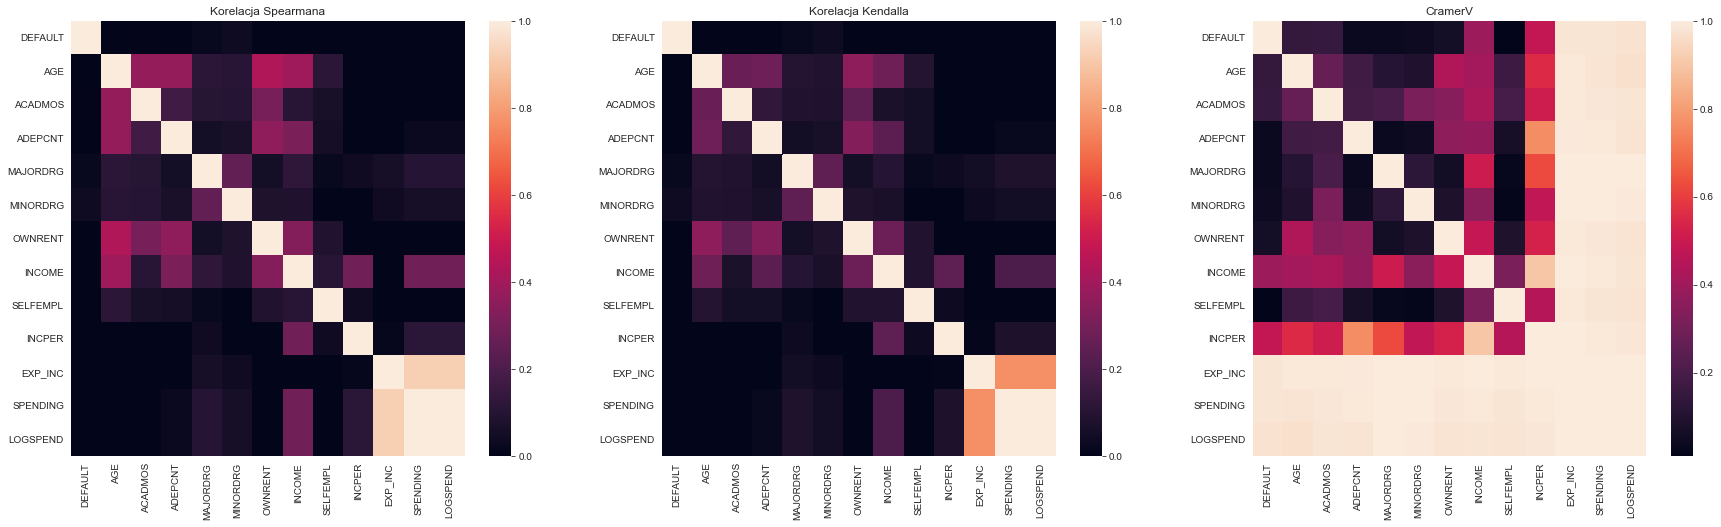

In [ ]:
plt.rcParams["figure.figsize"] = (30,8)

fig, ax =plt.subplots(1,3)
sns.heatmap(df.corr(method='spearman'),vmin=0.00, vmax=1.00,ax=ax[0]).set(title='Korelacja Spearmana')
sns.heatmap(df.corr(method='kendall'),vmin=0.00, vmax=1.00,ax=ax[1]).set(title='Korelacja Kendalla')
sns.heatmap(Cramer(df), ax=ax[2]).set(title='CramerV')

fig.show()


In [ ]:
df.drop(columns=['LOGSPEND', 'EXP_INC'], inplace=True)

Subsequently, I tested the correlation using 3 measures: Spearman, Kendall and V-Cramer. The Kendall measure showed the lowest correlations. The only variables at the unacceptable level of correlation (i.e. above 0.7) are the two expenditure variables. Taking this into account, they were removed from the data set. The V-Cramer's method showed an equally high correlation between the income variable and the income to expenditure ratio. It has been decided to reject LOGSPEND EXP_INC variables. LOGSPEND is strongly correlated with the variable SPENDING, and both have a lower Gini coefficient. The EXP_INC variable also has a strong correlation with the SPENDING variable.

<h3> Outliers </h3>

Logistic regression is sensitive to outliers. It was decided to remove 5% of the extreme values from the data set.

In [ ]:
lower_bound = df.quantile(0.025)
upper_bound = df.quantile(0.975)
num_of_outl = (df[upper_bound.index] > upper_bound).sum()
outliers = pd.DataFrame({'upper_bound':upper_bound, 'num_of_outliers_U':num_of_outl})

In [ ]:
outliers

,upper_bound,num_of_outliers_U
DEFAULT,1.000000,0
AGE,58.000000,228
ACADMOS,240.000000,238
ADEPCNT,4.000000,122
MAJORDRG,2.000000,63
MINORDRG,2.000000,179
OWNRENT,1.000000,0
INCOME,6250.000000,228
SELFEMPL,1.000000,0
INCPER,59632.000000,262


In [ ]:
for row in outliers.iterrows():
    df = df[df[row[0]] <= row[1]['upper_bound']]

In [ ]:
df.shape

(9149, 11)

Ultimately, the set has 9149 observations and 11 variables

<h3> Dataset splitting </h3>
The set was divided into two samples - training and test, so that 20% of the data set was in the test set along with the shifting of observations

In [ ]:
#listy zmiennych
kategoryczne_zmienne = ['ADEPCNT', 'MAJORDRG', 'MINORDRG', 'OWNRENT', 'SELFEMPL']
ciagle_zmienne = ['AGE', 'INCOME', 'INCPER', 'SPENDING']

In [ ]:
df_raw = df.copy()
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=2022)

<h3> Datasets </h3>

In order to investigate the influence of variables on the predictive qualities, it was decided to use the following data sets:
<ul>
<li> Raw data excluding variables removed from the set in the chapter above </li>
<li> Categorized continuous and transformed to WoE variables </li>
<li> Categorized Variables Using a Decision Tree </li>


<ul>

<h4> Create a set with WoE variables </h4>

To improve the quality of the model, the variables will be discredited continuously, and the next ones will be transformed into WoE values. This set will be used to check the probabilities of chances for individual variables.

In [ ]:
#selecting variables with more than 20 unique values
zmienne_do_kategoryzacji = [zmienna for zmienna in df.columns if df[zmienna].unique().shape[0] > 20]


In [ ]:
#kopia danych
df_woe = df_raw.copy()
df_train_woe = df_train.copy()
df_test_woe = df_test.copy()

In [ ]:
l=[]
card = pd.DataFrame()

#stworzenie 10 kategorii dla zmiennych
for x in zmienne_do_kategoryzacji:
    pomocnicza = pd.DataFrame()
    
    df_woe[x]= pd.qcut(df_woe[x], 10)
    pomocnicza['poz'] = df_woe[x]
    df_woe[x]= df_woe[x].cat.codes
    
    pomocnicza['poziom_zmiennej'] = df_woe[x]
    pomocnicza['zmienna'] = x
    
    card = pd.concat([card, pomocnicza])

df_train_woe, df_test_woe = train_test_split(df_woe, test_size=0.2, shuffle=True, random_state=2022)
df_woe_tab = df_woe.copy()
card = card.drop_duplicates().sort_values(['zmienna', 'poziom_zmiennej'])


In [ ]:
# IV and WoE counting function for variables
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        }) 
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset[col+'_WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({col+'_WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset[col+'_WoE']
    iv = dset['IV'].sum()
    dset = dset.sort_values(by=col+'_WoE')
    return dset, iv


In [ ]:
karta = pd.DataFrame()
lst = []
IV_df = pd.DataFrame(columns=['Variable','IV'])
for col in df_woe.columns:
    if col == 'DEFAULT': continue
    else:
        df_, iv = calculate_woe_iv(df_woe, col, 'DEFAULT')
        df_train_woe = df_train_woe.merge(df_[['Value',col+'_WoE']], left_on=col, right_on='Value', how='left')
        df_train_woe.drop(columns=[col, 'Value'], inplace=True)
        df_test_woe = df_test_woe.merge(df_[['Value',col+'_WoE']], left_on=col, right_on='Value', how='left')
        df_test_woe.drop(columns=[col, 'Value'], inplace=True)
        
        d1 = df_woe_tab[['DEFAULT',col]].merge(df_, left_on=col, right_on='Value').groupby(col).count().reset_index()
        d1['zmienna'] = col
        d1.rename(columns={col: 'poziom_zmiennej'}, inplace=True)
        d1 = d1.filter(['zmienna', 'poziom_zmiennej'])
        d1 = d1.merge(df_, left_on='poziom_zmiennej', right_on='Value', how='left').filter(['zmienna', 'poziom_zmiennej', col+'_WoE' ])
        d1.rename(columns={col+'_WoE': 'WoE'}, inplace=True)
        karta = pd.concat([karta, d1])


               
    lst.append(df_)
    IV_df = IV_df.append({
                "Variable" :col ,
                "IV" : iv,
                },ignore_index=True)
             


In [ ]:
karta = karta.merge(card, on=['zmienna', 'poziom_zmiennej'], how='left')
karta['poz'] = np.where(karta.poz.isnull(), karta.poziom_zmiennej, karta.poz)
karta['poz'] = karta['poz'].astype(str)

In [ ]:
IV_df

,Variable,IV
0,AGE,0.151069
1,ACADMOS,0.164773
2,ADEPCNT,0.013987
3,MAJORDRG,0.008762
4,MINORDRG,0.010729
5,OWNRENT,0.037228
6,INCOME,0.331796
7,SELFEMPL,0.000514
8,INCPER,0.365279
9,SPENDING,0.051281


Not all variables have a high predictive value. Variables that show very poor usefulness in predicting default (below the level of 0.02) were removed from the WoE set

In [ ]:
df_train_woe_all = df_train_woe.copy()
df_test_woe_all = df_test_woe.copy()

#list of variables below 0.02
to_drop = list(IV_df['Variable'].loc[IV_df['IV']<0.02])
to_drop = [x+'_WoE' for x in to_drop]

In [ ]:
# drop variables
df_train_woe.drop(columns=to_drop, inplace=True) 
df_test_woe.drop(columns=to_drop, inplace=True)

<h4>Utworzenie zbioru ze zmiennymi kategorycznymi drzew</h4>
Ostatni zbiór danych charakteryzuje się kategoryzacją zmiennych za pomocą drzew decyzyjnych, z maksymalną głebokością drzewa ustaloną na poziomie 3.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

#categorization function
def categorize_data(x, y):
    dt_model = DecisionTreeClassifier(max_depth = 3)
    dt_model.fit(x.values.reshape(-1, 1), y)
    categories = dt_model.apply(x.values.reshape(-1, 1))
    return dt_model, categories


In [ ]:
df_kat = df.copy()
df_train_kat = df_train.copy()
df_test_kat = df_test.copy()
target = 'DEFAULT'


for zmienna in zmienne_do_kategoryzacji:
    model, kategorie = categorize_data(df_train_kat[zmienna], df_train_kat[target])
    df_train_kat = df_train_kat.assign(_kat = kategorie)
    df_test_kat = df_test_kat.assign(_kat = model.apply(df_test_kat[zmienna].values.reshape(-1, 1)))
    
    nazwa_zmiennej = zmienna + '_kat'
    
    df_train_kat.rename(columns = {'_kat' : nazwa_zmiennej}, inplace = True)
    df_test_kat.rename(columns = {'_kat' : nazwa_zmiennej}, inplace = True)
    
df_train_kat.drop(columns = zmienne_do_kategoryzacji, inplace=True)
df_test_kat.drop(columns = zmienne_do_kategoryzacji, inplace=True)

<h1> Logit and Probit models for odds ratios </h1>

First, the odds ratios for the Logit and Probit models were checked. The Logit and Probit models are not subject to much overtraining as is the case with decision tree models, and as a result, no cross-validation has been applied.

In [ ]:
def build_model1(data_train, data_test ,features, target ,plots, model=Logit):
    #X_train, X_test, y_train, y_test = train_test_split(data[features_woe],data[target], test_size=0.2, shuffle=True, random_state=2022)
    X_train = data_train[features]
    y_train = data_train[target]
    X_test = data_test[features]
    y_test = data_test[target]

    model = model(y_train, X_train).fit(disp = 0)
    pre = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, pre)
    gini_score = 2 * auc(fpr, tpr) - 1
    #print('Gini score: {}.'.format(round(gini_score,3)))
    
    if plots == True:
        # ROC CURVE
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='blue',
                 lw=lw, label='ROC curve (area under curve = %0.3f)' % auc(fpr, tpr))
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc="lower right")
        plt.show()

        # DENSITY PLOT
        pre = pd.DataFrame(pre, columns = ['prob'])
        pre['pred_class'] = 1
        pre.loc[pre.prob < 0.5,'pred_class'] = 0
        pre['real_class'] = y_va

        sns.distplot(pre[pre.real_class == 0]['prob'], label = 'negatives').set(title = 'Density plot', xlabel = 'probability')
        sns.distplot(pre[pre.real_class == 1]['prob'], label = 'positives').set(title = 'Density plot', xlabel = 'probability')
        plt.legend()
        plt.show()
    return gini_score, model

In [ ]:
for zmienna in ['ADEPCNT', 'MAJORDRG', 'MINORDRG']:
    df_raw[zmienna] = df_raw[zmienna].astype(str)
df_train, df_test = train_test_split(df_raw, test_size=0.2, shuffle=True, random_state=2022)

In [ ]:
for zmienna in ['ADEPCNT', 'MAJORDRG', 'MINORDRG']:
    df_test_kat[zmienna] = df_test_kat[zmienna].astype(str)
    df_train_kat[zmienna] = df_train_kat[zmienna].astype(str)

In [ ]:
df_train = pd.get_dummies(df_train, drop_first=True)
df_test = pd.get_dummies(df_test, drop_first=True)
df_train_kat = pd.get_dummies(df_train_kat, drop_first=True)
df_test_kat = pd.get_dummies(df_test_kat, drop_first=True)

In [ ]:
# creating a list of variables
features = list(df_test.columns)
features.remove('DEFAULT')
features_woe = list(df_test_woe.columns)
features_woe.remove('DEFAULT')
features_woe_all = list(df_test_woe_all.columns)
features_woe_all.remove('DEFAULT')
features_kat = list(df_test_kat.columns)
features_kat.remove('DEFAULT')
target='DEFAULT'

In [ ]:
#all variables
score_raw_logit, model_raw_logit = build_model1(data_train = df_train, data_test = df_test ,features = features, target=target ,plots=False, model=Logit)
score_raw_probit, model_raw_probit = build_model1(data_train = df_train, data_test = df_test ,features = features, target=target ,plots=False, model=Probit)
#WoE
score_woe_logit, model_woe_logit = build_model1(data_train = df_train_woe, data_test = df_test_woe ,features = features_woe, target=target ,plots=False, model=Logit)
score_woe_probit, model_woe_probit = build_model1(data_train = df_train_woe, data_test = df_test_woe ,features = features_woe, target=target ,plots=False, model=Probit)
#Woe all 
score_woe_logit_all, model_woe_logit_all = build_model1(data_train = df_train_woe_all, data_test = df_test_woe_all ,features = features_woe_all, target=target ,plots=False, model=Logit)
score_woe_probit_all, model_woe_probit_all = build_model1(data_train = df_train_woe_all, data_test = df_test_woe_all ,features = features_woe_all, target=target ,plots=False, model=Probit)
#cat decistion tree
score_logit_kat, model_logit_kat = build_model1(data_train = df_train_kat, data_test = df_test_kat ,features = features_kat, target=target ,plots=False, model=Logit)
score_probit_kat, model_probit_kat = build_model1(data_train = df_train_kat, data_test = df_test_kat ,features = features_kat, target=target ,plots=False, model=Probit)


In [ ]:
pd.DataFrame([[score_raw_logit,score_raw_probit, score_woe_logit,score_woe_probit,score_woe_logit_all,score_woe_probit_all, score_logit_kat, score_probit_kat  ]], 
             columns = ['Logit RAW', 'Probit RAW', 'Logit WOE', 'Probit WOE', 'Logit WOE ALL', 'Probit WOE ALL', 'Logit DT Kat', 'Probit DT Kat'])

,Logit RAW,Probit RAW,Logit WOE,Probit WOE,Logit WOE ALL,Probit WOE ALL,Logit DT Kat,Probit DT Kat
0,0.302595,0.301759,0.439848,0.442755,0.443629,0.446294,0.324685,0.32645


The best model in terms of the Gini measure is the Probit model estimated on all WoE variables. The second-best result is also the probit model for WoE variables with the removal of variables with an IV value below 0.02. However, taking into account that the model is only worse by approx. 0.004, with the expulsion of 4 variables, it was possible to simplify the functional form of the model, slightly worsening the result. The same is true of the Logit model, which differs slightly from the probit model.

Then, the estimation results for the four best estimates were checked - Probit and Logit with WoE variables

In [ ]:
Wyniki_estymacji = summary_col([model_woe_probit,model_woe_logit,model_woe_probit_all, model_woe_probit_all],model_names=['Probit WoE', 'Logit Woe', 'Probit WoE ALL', 'Logit WoE ALL'], stars=True)
Wyniki_estymacji

,Probit WoE,Logit Woe,Probit WoE ALL,Logit WoE ALL
ACADMOS_WoE,-0.3705***,-0.5986***,-0.3683***,-0.3683***
,(0.0378),(0.0616),(0.0380),(0.0380)
ADEPCNT_WoE,,,-0.7421***,-0.7421***
,,,(0.1292),(0.1292)
AGE_WoE,-0.5538***,-0.9634***,-0.5917***,-0.5917***
,(0.0429),(0.0752),(0.0434),(0.0434)
INCOME_WoE,-0.2137***,-0.3473***,-0.2210***,-0.2210***
,(0.0294),(0.0479),(0.0296),(0.0296)
INCPER_WoE,-0.2009***,-0.3307***,-0.1956***,-0.1956***
,(0.0288),(0.0470),(0.0289),(0.0289)


All the variables in the models except SELFEMPL_WoE are significant at the 1% level. It is possible that the other three significant variables - ADEPCNT_WoE, MAJORDRG_WoE, MINORDRG_WoE constitute the difference in the results between the estimates on both data sets. To improve the model, the Probit model was additionally estimated, for WoE variables, excluding only the insignificant variable - SELFEMPL_WoE

In [ ]:
features_woe_self = features_woe_all.copy()
features_woe_self.remove('SELFEMPL_WoE')

score_woe_probit_self, model_woe_probit_self = build_model1(data_train = df_train_woe_all.drop(columns=['SELFEMPL_WoE']), data_test = df_test_woe_all.drop(columns=['SELFEMPL_WoE']),
                                                            features = features_woe_self, target=target ,plots=False, model=Probit)
score_woe_logit_self, model_woe_logit_self = build_model1(data_train = df_train_woe_all.drop(columns=['SELFEMPL_WoE']), data_test = df_test_woe_all.drop(columns=['SELFEMPL_WoE']),
                                                            features = features_woe_self, target=target ,plots=False, model=Logit)

print('Gini Logit', score_woe_logit_self )
print('Gini Probit', score_woe_probit_self )

Gini Logit 0.4456866637893828
Gini Probit 0.448372895986189


The results for both the Logit and Probit models improved. The Gini measures are of better value than the earlier models that take into account 6 and 10 variables.

In [ ]:
szanse.reset_index(inplace=True)
szanse['zmienna'] = szanse['index'].str[:-4]


In [ ]:
karta = karta.merge(szanse, on='zmienna').drop(columns='index')
karta = karta.filter(['zmienna', 'poz', 'Probit', 'WoE'])

In [ ]:
pd.set_option('display.max_rows', None)

karta.set_index(['zmienna','Probit','poz'])

WoE
zmienna  Probit   poz                           
AGE      -0.44542 (17.999, 22.0]       -0.640434
                  (22.0, 24.0]         -0.103041
                  (24.0, 26.0]          0.198865
                  (26.0, 28.0]          0.001224
                  (28.0, 30.0]          0.011242
                  (30.0, 33.0]          0.245345
                  (33.0, 36.0]          0.067080
                  (36.0, 40.0]          0.238972
                  (40.0, 45.0]          0.251999
                  (45.0, 58.0]          0.127625
ACADMOS  -0.30848 (-0.001, 6.0]         0.131899
                  (6.0, 12.0]          -0.003488
                  (12.0, 14.0]          0.400647
                  (14.0, 24.0]          0.056876
                  (24.0, 28.0]          0.003573
                  (28.0, 38.0]         -0.216662
                  (38.0, 54.0]         -0.035318
                  (54.0, 82.4]         -0.172041
                  (82.4, 127.0]        -0.025585
                  (127.0, 240.0]        0.094315
ADEPCNT  -0.52550 0                     0.060746
                  1                    -0.176325
                  2                    -0.060631
                  3                     0.221955
                  4                    -0.124199
MAJORDRG -0.64602 0                     0.027643
                  1                    -0.307488
                  2                     0.068770
MINORDRG -0.50231 0                     0.041427
                  1                    -0.214168
                  2                    -0.350671
OWNRENT  -0.32267 0                    -0.162078
                  1                     0.230403
INCOME   -0.19779 (49.999, 1400.0]     -0.739845
                  (1400.0, 1625.0]     -0.567325
                  (1625.0, 1820.0]     -0.185183
                  (1820.0, 2000.0]     -0.011416
                  (2000.0, 2191.667]    0.039110
                  (2191.667, 2500.0]    0.120301
                  (2500.0, 2708.333]    0.451456
                  (2708.333, 3083.333]  0.549880
                  (3083.333, 3750.0]    0.555540
                  (3750.0, 6250.0]      0.968631
INCPER   -0.17707 (699.999, 8700.0]    -0.516288
                  (8700.0, 11380.0]    -0.301711
                  (11380.0, 14279.4]    0.084600
                  (14279.4, 16800.0]   -0.211008
                  (16800.0, 19584.0]   -0.037766
                  (19584.0, 22000.0]   -0.045882
                  (22000.0, 25000.0]    0.188212
                  (25000.0, 30000.0]    0.430810
                  (30000.0, 35393.6]    0.309410
                  (35393.6, 59600.0]    0.454341
SPENDING  0.50947 (0.11, 19.101]       -0.622711
                  (19.101, 44.12]       0.032713
                  (44.12, 69.773]      -0.004818
                  (69.773, 98.938]     -0.053163
                  (98.938, 132.788]    -0.198658
                  (132.788, 173.557]    0.006355
                  (173.557, 226.811]    0.317796
                  (226.811, 307.017]    0.301801
                  (307.017, 441.501]    0.255081
                  (441.501, 964.887]    0.286021

For the logit and probit models, the direction of the influence of variables is identical. Analyzing the best-performing probit model, greater card spending increases the probability of default by 50%. The number of reports of serious infringements reduces the probability by around 64%

<h1> Predictive models </h1>

<h2> Variable Selection </h2>

WoE variables, despite high efficiency for Logit and Probit models, may not bring the expected results in the case of other types of models, e.g. decision trees. To select the appropriate variables for the remaining models, recursive variable elimination with cross-validation was used, using the Random Forest model on the "raw" data.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

df_train, df_test = train_test_split(df_raw, test_size=0.2, shuffle=True, random_state=2022)
features = list(df_raw.columns)
features.remove('DEFAULT')

feature_selector = RFECV(RandomForestClassifier(), step=1, scoring='roc_auc', cv=5, verbose=1)

feature_selector.fit(df_train[features], df_train[target])
print('Wybrane zmienne:', feature_selector.n_features_)

Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 10 features.
Fitting estimato

In [ ]:
selected_features = [f for f in df_train[features].columns[feature_selector.ranking_ == 1]]
selected_features

['AGE',
 'ACADMOS',
 'ADEPCNT',
 'MAJORDRG',
 'MINORDRG',
 'OWNRENT',
 'INCOME',
 'SELFEMPL',
 'INCPER',
 'SPENDING']

Recursive elimination of variables showed that it is best to select only 8 variables for the model. In order to improve the predictive quality of the models, three data sets were used in the present analysis:

<ul>
<li> Best collection with WoE variables from the previous chapter </li>
<li> Variables Included After Recursive Variable Elimination </li>
<li> Raw data </li>
</ul>

The models used a 5-fold cross-validation and the final prediction on the validation (test) set, on data that did not participate in the model learning process.

In [ ]:
df_train_rfecv = df_train.filter(selected_features)
df_test_rfecv = df_test.filter(selected_features)
df_woe_train = df_train_woe_all.drop(columns=['SELFEMPL_WoE'])
df_woe_test = df_train_woe_all.drop(columns=['SELFEMPL_WoE'])
features_woe = list(df_woe_train.columns)
features_woe.remove('DEFAULT')

In [ ]:
for x in ['ADEPCNT', 'MAJORDRG', 'MINORDRG']:
    df_train[x] = df_train[x].astype(int)
    df_test[x] = df_test[x].astype(int)

<h1>Logistic regression</h1>

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform


In [ ]:
#model = LogisticRegression()
model = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2022)
space = dict()
#space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
#space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
#space['C'] = loguniform(1e-5, 100)
space['max_depth'] = range(3,8)
search = RandomizedSearchCV(model,space, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=2022)
result = search.fit(df_train[features], df_train[target])


In [ ]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score, recall_score, precision_score, average_precision_score, precision_recall_curve,accuracy_score
from sklearn.ensemble import RandomForestClassifier

#wrapper 
def wrapper_sklearn(data = df, nFolds = 5, data_test=df_test,model=RandomForestClassifier ,randomState=2022,features=features, target=target, debug=False, importance=False,*args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    AUCtrainResults=[]
    AUCtestResults=[]
    
    predictions = []
    indices = []
    for train, test in kf.split(data.index.values):
        
        clf = model(*args, **kwargs)
        clf.fit(data.iloc[train][features], data.iloc[train][target])
        predsTrain = clf.predict_proba(data.iloc[train][features])[:,1]
        preds = clf.predict_proba(data.iloc[test][features])[:,1]

        predictions.append(preds.tolist().copy())
        indices.append(data.iloc[test].index.tolist().copy())
        AUCtrainScore = roc_auc_score((data[target].iloc[train]==1).astype(int), predsTrain)
        AUCtestScore = roc_auc_score((data[target].iloc[test]==1).astype(int), preds)
        
        AUCtrainResults.append(AUCtrainScore)
        AUCtestResults.append(AUCtestScore)
        
    preds_final = clf.predict_proba(data_test[features])[:,1]
    fpr, tpr, thresholds = roc_curve(data_test[target], preds_final)
    gini_score = 2 * auc(fpr, tpr) - 1
    indices_final = data_test.index.tolist().copy()
    AUC_final = roc_auc_score((data_test[target]).astype(int), preds_final)
        
    punkty_odciecia = np.arange(0, 1.01, 0.01)

    wyniki = {}
    for punkt in punkty_odciecia:
        tn, fp, fn, tp = confusion_matrix(data_test[target], preds_final>punkt).ravel()
        koszt = tn * -15 + fn * 75
        wyniki[punkt] = koszt
    # results in data series.
    wyniki = pd.Series(wyniki)
    npo = wyniki.iloc[wyniki.argmin():wyniki.argmin()+1].index[0]
    
    if importance==True:
        imp = clf.feature_importances_
        return predictions, indices, AUCtrainResults, AUCtestResults, gini_score, preds_final, AUC_final, indices_final, fpr, tpr, thresholds, npo, imp
    else:
        return predictions, indices, AUCtrainResults, AUCtestResults, gini_score, preds_final, AUC_final, indices_final, fpr, tpr, thresholds, npo

<h2>Logistic regression</h2>

In [ ]:
#RFECV
predictions, indices, AUCtrainResults, AUCtestResults, gini_score, preds_final, AUC_final, indices_final, fpr_r, tpr_r, thresholds, npo = wrapper_sklearn(data=df_train, data_test=df_test, features=selected_features, target=target, model=LogisticRegression)
print('RFECV','Test AUC',np.mean(AUCtestResults), 'Train AUC' ,np.mean(AUCtrainResults), 'GINI:',gini_score, 'AUC valid',AUC_final )
#WOE
predictions, indices, AUCtrainResults, AUCtestResults, gini_score, preds_final, AUC_final, indices_final, fpr_w, tpr_w, thresholds, npo = wrapper_sklearn(data=df_woe_train,data_test=df_woe_test, features=features_woe, target=target, model=LogisticRegression)
print('WOE','Test AUC',np.mean(AUCtestResults), 'Train AUC' ,np.mean(AUCtrainResults), 'GINI:',gini_score, 'AUC valid',AUC_final )
#RAW
predictions, indices, AUCtrainResults, AUCtestResults, gini_score, preds_final, AUC_final, indices_final, fpr_raw, tpr_raw, thresholds, npo = wrapper_sklearn(data=df_train,data_test=df_test, features=features, target=target, model=LogisticRegression)
print('RAW','Test AUC',np.mean(AUCtestResults), 'Train AUC' ,np.mean(AUCtrainResults), 'GINI:',gini_score, 'AUC valid',AUC_final )


RFECV Test AUC 0.6401020961842309 Train AUC 0.6424777053687809 GINI: 0.3439378506689683 AUC valid 0.6719689253344842
WOE Test AUC 0.7463859299964568 Train AUC 0.7502000918948738 GINI: 0.4971413604509247 AUC valid 0.7485706802254624
RAW Test AUC 0.640090908236418 Train AUC 0.6436746266297707 GINI: 0.3439378506689683 AUC valid 0.6719689253344842


The set of WoE variables has the best values for logistic regression. Models on an unselected and selected set have the same value.

In [ ]:
for zbior_zmienne in [[df_train,df_test, selected_features ],[df_woe_train,df_woe_test, features_woe ],[df_train,df_test, features]]:
    results = {}
    for x in range(25):
        try:
            penalty = random.choice(['l1', 'l2', 'elasticnet', 'none'])
            solver = random.choice(['newton-cg', 'lbfgs', 'sag', 'saga'])


            predictions, indices, AUCtrainResults, AUCtestResults, gini_score, preds_final, AUC_final, indices_final, fpr_r, tpr_r, thresholds, npo = wrapper_sklearn(data=zbior_zmienne[0], 
            data_test=zbior_zmienne[1], penalty = penalty, solver=solver,features=zbior_zmienne[2], target=target, model=LogisticRegression)

            results[np.mean(AUCtestResults)] = {'AUCtestResults': np.mean(AUCtestResults),
                                               'AUCtrainResults': np.mean(AUCtrainResults),
                                                'AUCval': np.mean(AUC_final),
                                                'gini': gini_score,
                                                'penalty': penalty,
                                                'solver': solver
                                               }
        except: pass
    print(results[max(list(results.keys()))])

{'AUCtestResults': 0.6458468704693471, 'AUCtrainResults': 0.6543719220491069, 'AUCval': 0.6575779024600776, 'gini': 0.31515580492015527, 'penalty': 'l2', 'solver': 'newton-cg'}
{'AUCtestResults': 0.7464617434165082, 'AUCtrainResults': 0.7505559400065813, 'AUCval': 0.7490802281530275, 'gini': 0.4981604563060551, 'penalty': 'none', 'solver': 'saga'}
{'AUCtestResults': 0.6503344541630187, 'AUCtrainResults': 0.6606162537474669, 'AUCval': 0.6466189037548555, 'gini': 0.29323780750971107, 'penalty': 'none', 'solver': 'newton-cg'}


<h2>Random Forest</h2>

In [ ]:
#RFECV
predictions, indices, AUCtrainResults, AUCtestResults, gini_score, preds_final, AUC_final, indices_final, fpr_r, tpr_r, thresholds, npo = wrapper_sklearn(data=df_train, data_test=df_test, features=selected_features, target=target, model=RandomForestClassifier)
print('RFECV','Test AUC',np.mean(AUCtestResults), 'Train AUC' ,np.mean(AUCtrainResults), 'GINI:',gini_score, 'AUC valid',AUC_final )
#WOE
predictions, indices, AUCtrainResults, AUCtestResults, gini_score, preds_final, AUC_final, indices_final, fpr_w, tpr_w, thresholds, npo = wrapper_sklearn(data=df_woe_train,data_test=df_woe_test, features=features_woe, target=target, model=RandomForestClassifier)
print('WOE','Test AUC',np.mean(AUCtestResults), 'Train AUC' ,np.mean(AUCtrainResults), 'GINI:',gini_score, 'AUC valid',AUC_final )
#RAW
predictions, indices, AUCtrainResults, AUCtestResults, gini_score, preds_final, AUC_final, indices_final, fpr_raw, tpr_raw, thresholds, npo = wrapper_sklearn(data=df_train,data_test=df_test, features=features, target=target, model=RandomForestClassifier)
print('RAW','Test AUC',np.mean(AUCtestResults), 'Train AUC' ,np.mean(AUCtrainResults), 'GINI:',gini_score, 'AUC valid',AUC_final )


RFECV Test AUC 0.6339132048763412 Train AUC 1.0 GINI: 0.2838877859300819 AUC valid 0.641943892965041
WOE Test AUC 0.6929181053004523 Train AUC 0.9999674293395264 GINI: 0.9295327168027632 AUC valid 0.9647663584013816
RAW Test AUC 0.6320046226826276 Train AUC 1.0 GINI: 0.25448079413034086 AUC valid 0.6272403970651704


All models of the Random Forest are retrained. This is evidenced by the high average value of AUC of folds on the training set. For this purpose, a loop to find the best parameters was used to eliminate over-training of the model for each of the datasets.

In [ ]:
for zbior_zmienne in [[df_train,df_test, selected_features ],[df_woe_train,df_woe_test, features_woe ],[df_train,df_test, features]]:
    results = {}
    for x in range(25):
        try:
            n_estimators_ = random.randint(80,300)
            criterion_ = random.choice(['entropy', 'gini'])
            max_depth_ = random.randint(2,8)
            min_samples_split_ = random.randint(2,20)
            min_samples_leaf_ = random.randint(1,20)
            min_impurity_decrease_ = random.uniform(0, 0.30)

            predictions, indices, AUCtrainResults, AUCtestResults, gini_score, preds_final, AUC_final, indices_final, fpr_r, tpr_r, thresholds, npo = wrapper_sklearn(data=zbior_zmienne[0], data_test=zbior_zmienne[1], 
                                                                                                                                                        features=zbior_zmienne[2], target=target,
                                                                                                                                                        model=RandomForestClassifier,
                                                                                                                                                        n_estimators = n_estimators_,
                                                                                                                                                        criterion = criterion_,
                                                                                                                                                        max_depth = max_depth_,
                                                                                                                                                        min_samples_split = min_samples_split_,
                                                                                                                                                        min_samples_leaf = min_samples_leaf_,
                                                                                                                                                        min_impurity_decrease = min_impurity_decrease_
                                                                                                                                                        )

            results[np.mean(AUCtestResults)] = {'AUCtestResults': np.mean(AUCtestResults),
                                       'AUCtrainResults': np.mean(AUCtrainResults),
                                        'AUCVal' : AUC_final,
                                        'gini': gini_score,
                                        'n_estimators': n_estimators_,
                                        'max_depth': max_depth_,
                                        'min_samples_split': min_samples_split_,
                                        'min_samples_leaf': min_samples_leaf_,
                                        'min_impurity_decrease': min_impurity_decrease_}        
        except: pass
        
    print(results[max(list(results.keys()))])

{'AUCtestResults': 0.5883201604796738, 'AUCtrainResults': 0.6016346471636339, 'AUCVal': 0.6153819594302978, 'gini': 0.23076391886059566, 'n_estimators': 86, 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.014881349080264693}
{'AUCtestResults': 0.6467604732471679, 'AUCtrainResults': 0.6521434116574578, 'AUCVal': 0.6496424966334943, 'gini': 0.29928499326698854, 'n_estimators': 295, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.006901023285726393}
{'AUCtestResults': 0.6565513630723949, 'AUCtrainResults': 0.6815428378702353, 'AUCVal': 0.6778126888217523, 'gini': 0.35562537764350455, 'n_estimators': 127, 'max_depth': 2, 'min_samples_split': 15, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.003067360831516308}


<h2>XGBoost</h2>

In [ ]:
#RFECV
predictions, indices, AUCtrainResults, AUCtestResults, gini_score, preds_final, AUC_final, indices_final, fpr_r, tpr_r, thresholds, npo = wrapper_sklearn(data=df_train, data_test=df_test, features=selected_features, target=target, model=XGBClassifier)
print('RFECV','Test AUC',np.mean(AUCtestResults), 'Train AUC' ,np.mean(AUCtrainResults), 'GINI:',gini_score, 'AUC valid',AUC_final )
#WOE
predictions, indices, AUCtrainResults, AUCtestResults, gini_score, preds_final, AUC_final, indices_final, fpr_w, tpr_w, thresholds, npo = wrapper_sklearn(data=df_woe_train,data_test=df_woe_test, features=features_woe, target=target, model=XGBClassifier)
print('WOE','Test AUC',np.mean(AUCtestResults), 'Train AUC' ,np.mean(AUCtrainResults), 'GINI:',gini_score, 'AUC valid',AUC_final )
#RAW
predictions, indices, AUCtrainResults, AUCtestResults, gini_score, preds_final, AUC_final, indices_final, fpr_raw, tpr_raw, thresholds, npo = wrapper_sklearn(data=df_train,data_test=df_test, features=features, target=target, model=XGBClassifier)
print('RAW','Test AUC',np.mean(AUCtestResults), 'Train AUC' ,np.mean(AUCtrainResults), 'GINI:',gini_score, 'AUC valid',AUC_final )


RFECV Test AUC 0.6277109932142411 Train AUC 0.9954088209782783 GINI: 0.18346137246439365 AUC valid 0.5917306862321968
WOE Test AUC 0.6698813432026919 Train AUC 0.9816326272872423 GINI: 0.8372215091447457 AUC valid 0.9186107545723728
RAW Test AUC 0.618386501214385 Train AUC 0.9956309285390612 GINI: 0.2070608545533017 AUC valid 0.6035304272766508


Overfitting on the test set is also noticeable for XGBoost

In [ ]:
for zbior_zmienne in [[df_train,df_test, selected_features ],[df_woe_train,df_woe_test, features_woe ],[df_train,df_test, features]]:
    results = {}
    for x in range(25):
        try:
            n_estimators_ = random.randint(80,300)
            criterion_ = random.choice(['entropy', 'gini'])
            max_depth_ = random.randint(2,8)
            min_samples_split_ = random.randint(2,20)
            min_samples_leaf_ = random.randint(1,20)
            min_impurity_decrease_ = random.uniform(0, 0.30)

            predictions, indices, AUCtrainResults, AUCtestResults, gini_score, preds_final, AUC_final, indices_final, fpr_r, tpr_r, thresholds, npo = wrapper_sklearn(data=zbior_zmienne[0], data_test=zbior_zmienne[1], 
                                                                                                                                                        features=zbior_zmienne[2], target=target,
                                                                                                                                                        model=XGBClassifier,subsample=subsample,
                                                                                                                                                        max_depth=max_depth,colsample_bytree = colsample_bytree, 
                                                                                                                                                        lambdaX=lambdaX,gamma = gamma, silent=True, verbosity=0)

            results[np.mean(AUCtestResults)] = {'AUCtestResults': np.mean(AUCtestResults),
                                               'AUCtrainResults': np.mean(AUCtrainResults),
                                                'AUCtrainResults': AUC_final,
                                                'gini': gini_score,
                                                'subsample': subsample,
                                                'max_depth': max_depth,
                                                'colsample_bytree': colsample_bytree,
                                                'lambdaX': lambdaX,
                                                'gamma': gamma}
        except: pass
        
    print(results[max(list(results.keys()))])

{'AUCtestResults': 0.6491790971889159, 'AUCtrainResults': 0.6101596892533449, 'gini': 0.2203193785066897, 'subsample': 0.2549368606242953, 'max_depth': 5, 'colsample_bytree': 0.22082581502828014, 'lambdaX': 8.997779610321434, 'gamma': 5.011492877714217}
{'AUCtestResults': 0.7269052057619121, 'AUCtrainResults': 0.7529112970391145, 'gini': 0.505822594078229, 'subsample': 0.2549368606242953, 'max_depth': 5, 'colsample_bytree': 0.22082581502828014, 'lambdaX': 8.997779610321434, 'gamma': 5.011492877714217}
{'AUCtestResults': 0.6576442647957021, 'AUCtrainResults': 0.6203694432455762, 'gini': 0.24073888649115238, 'subsample': 0.2549368606242953, 'max_depth': 5, 'colsample_bytree': 0.22082581502828014, 'lambdaX': 8.997779610321434, 'gamma': 5.011492877714217}


<h2>Probit</h2>

In [ ]:
def wrapper_statsmodels(data = df, nFolds = 5, data_test=df_test,model=Probit ,randomState=2022,features=features, target=target, debug=False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    AUCtrainResults=[]
    AUCtestResults=[]
    
    X_val = data_test[features]
    y_val = data_test[target]
    predictions = []
    indices = []
    for train, test in kf.split(data.index.values):
        
        X_train = data.iloc[train][features]
        y_train = data.iloc[train][target]
        X_test = data.iloc[test][features]
        y_test = data.iloc[test][target]

        
        model = Probit(y_train, X_train).fit(disp=0)
        predsTrain = model.predict(X_train)
        preds = model.predict(X_test)
        AUCtrainScore = roc_auc_score(y_train, predsTrain)
        AUCtestScore = roc_auc_score(y_test, preds)
        
        AUCtrainResults.append(AUCtrainScore)
        AUCtestResults.append(AUCtestScore)
        
    preds_final = model.predict(X_val)
    fpr, tpr, thresholds = roc_curve(data_test[target], preds_final)
    gini_score = 2 * auc(fpr, tpr) - 1
    AUC_final = roc_auc_score((data_test[target]).astype(int), preds_final)
        
    punkty_odciecia = np.arange(0, 1.01, 0.01)

    wyniki = {}
    for punkt in punkty_odciecia:
        tn, fp, fn, tp = confusion_matrix(y_val, preds_final>punkt).ravel()
        koszt = tn * -15 + fn * 75
        wyniki[punkt] = koszt
    # Wyniki zapisuję w serii danych.
    wyniki = pd.Series(wyniki)
    nop = wyniki.iloc[wyniki.argmin():wyniki.argmin()+1].index[0]
    
    #m = np.argmax(tpr - fpr)
    #nop = thresholds[m]

        
    return predictions, indices, AUCtrainResults, AUCtestResults, gini_score, preds_final, AUC_final, indices_final, fpr, tpr, thresholds, nop

In [ ]:
#RFECV
AUCtrainResults, AUCtestResults, gini_score, preds_final, AUC_final, fpr, tpr, thresholds, npo = wrapper_statsmodels(data=df_train, data_test=df_test, features=selected_features, target=target, model=Probit)
print('RFECV','Test AUC',np.mean(AUCtestResults), 'Train AUC' ,np.mean(AUCtrainResults), 'GINI:',gini_score, 'AUC valid',AUC_final )
#WOE
AUCtrainResults, AUCtestResults, gini_score, preds_final, AUC_final, fpr, tpr, thresholds, npo = wrapper_statsmodels(data=df_woe_train,data_test=df_woe_test, features=features_woe, target=target, model=Probit)
print('WOE','Test AUC',np.mean(AUCtestResults), 'Train AUC' ,np.mean(AUCtrainResults), 'GINI:',gini_score, 'AUC valid',AUC_final )
#RAW
AUCtrainResults, AUCtestResults, gini_score, preds_final, AUC_final, fpr, tpr, thresholds, npo = wrapper_statsmodels(data=df_train,data_test=df_test, features=features, target=target, model=Probit)
print('RAW','Test AUC',np.mean(AUCtestResults), 'Train AUC' ,np.mean(AUCtrainResults), 'GINI:',gini_score, 'AUC valid',AUC_final )


RFECV Test AUC 0.6485104277303554 Train AUC 0.654605517854847 GINI: 0.32092878722485985 AUC valid 0.6604643936124299
WOE Test AUC 0.7142711918104427 Train AUC 0.716733677102628 GINI: 0.4370374076286725 AUC valid 0.7185187038143362
RAW Test AUC 0.6481906764338419 Train AUC 0.6549885069770284 GINI: 0.3095347432024169 AUC valid 0.6547673716012085


<h2> Compare the best models </h2>

In [ ]:
predictions, indices, AUCtrainResults, AUCtestResults, gini_score_prob, preds_final, AUC_final_prob, indices_final, fpr_prob, tpr_prob, thresholds_prob, npo_prob = wrapper_statsmodels(data=df_woe_train,
                                                                                                                                                                    data_test=df_woe_test,features=features_woe, target=target, model=Probit)

predictions, indices, AUCtrainResults, AUCtestResults, gini_score_xgb, preds_final, AUC_final_xgb, indices_final, fpr_xgb, tpr_xgb, thresholds_xgb, npo_xgb, imp_xgb = wrapper_sklearn(data=df_woe_train,data_test=df_woe_test,
                                                                                                                                                                    features=features_woe,
                                                                                                                                                                    target=target, model=XGBClassifier,
                                                                                                                                                                    subsample =  0.2549368606242953,
                                                                                                                                                                    max_depth =  5,
                                                                                                                                                                    colsample_bytree = 0.22082581502828014,
                                                                                                                                                                    lambdaX =  8.997779610321434,
                                                                                                                                                                    gamma = 5.011492877714217)



predictions, indices, AUCtrainResults, AUCtestResults, gini_score_rf, preds_final, AUC_final_rf, indices_final, fpr_rf, tpr_rf, thresholds_rf, npo_rf, imp_rf = wrapper_sklearn(data=df_woe_train,data_test=df_woe_test, 
                                                                                                                                                    features=features_woe, target=target, 
                                                                                                                                                    model=RandomForestClassifier,
                                                                                                                                                    n_estimators = 295,max_depth = 7,
                                                                                                                                                    min_samples_split =  15,
                                                                                                                                                    min_samples_leaf = 2,
                                                                                                                                                    min_impurity_decrease =  0.006901023285726393)

predictions, indices, AUCtrainResults, AUCtestResults, gini_score_lr, preds_final, AUC_final_lr, indices_final, fpr_lr, tpr_lr, thresholds_lr, npo_lr = wrapper_sklearn(data=df_woe_train,data_test=df_woe_test, 
                                                                                                                                                     features=features_woe, target=target, 
                                                                                                                                                     model=LogisticRegression, solver='saga')



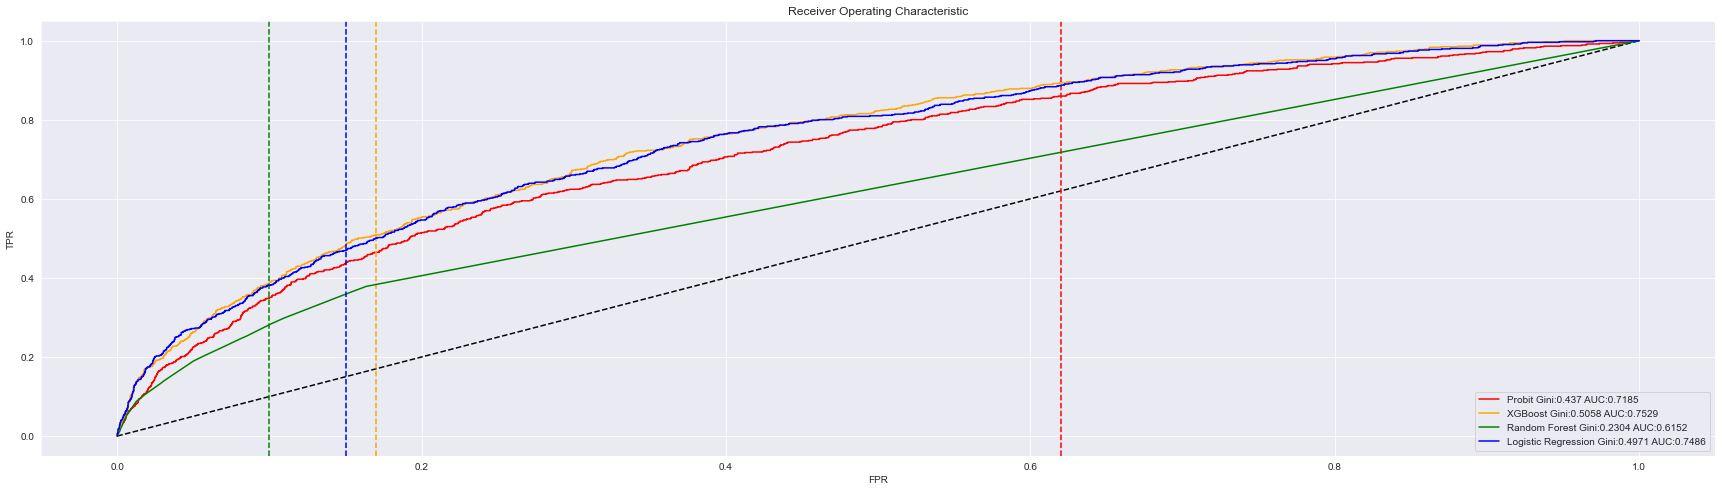

In [ ]:
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr_prob, tpr_probit, color='red',label="Probit"+ ' Gini:' +str(round(gini_score_prob, 4)) + ' AUC:' + str(round(AUC_final_prob,4)))
plt.axvline(x=npo_prob, color='r', linestyle='--')

plt.plot(fpr_xgb, tpr_xgb, color='orange' ,label= "XGBoost"+ ' Gini:' + str(round(gini_score_xgb,4)) + ' AUC:' + str(round(AUC_final_xgb, 4)))
plt.axvline(x=npo_xgb,color='orange', linestyle='--')

plt.plot(fpr_rf, tpr_rf, color='green' ,label= "Random Forest"+ ' Gini:' + str(round(gini_score_rf,4)) + ' AUC:' + str(round(AUC_final_rf,4)))
plt.axvline(x=npo_rf,color='green', linestyle='--')

plt.plot(fpr_lr, tpr_lr, color='blue', label= "Logistic Regression"+ ' Gini:' + str(round(gini_score_lr,4)) + ' AUC:' + str(round(AUC_final_lr,4)))
plt.axvline(x=npo_lr,color='blue', linestyle='--')

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

<BarContainer object of 9 artists>

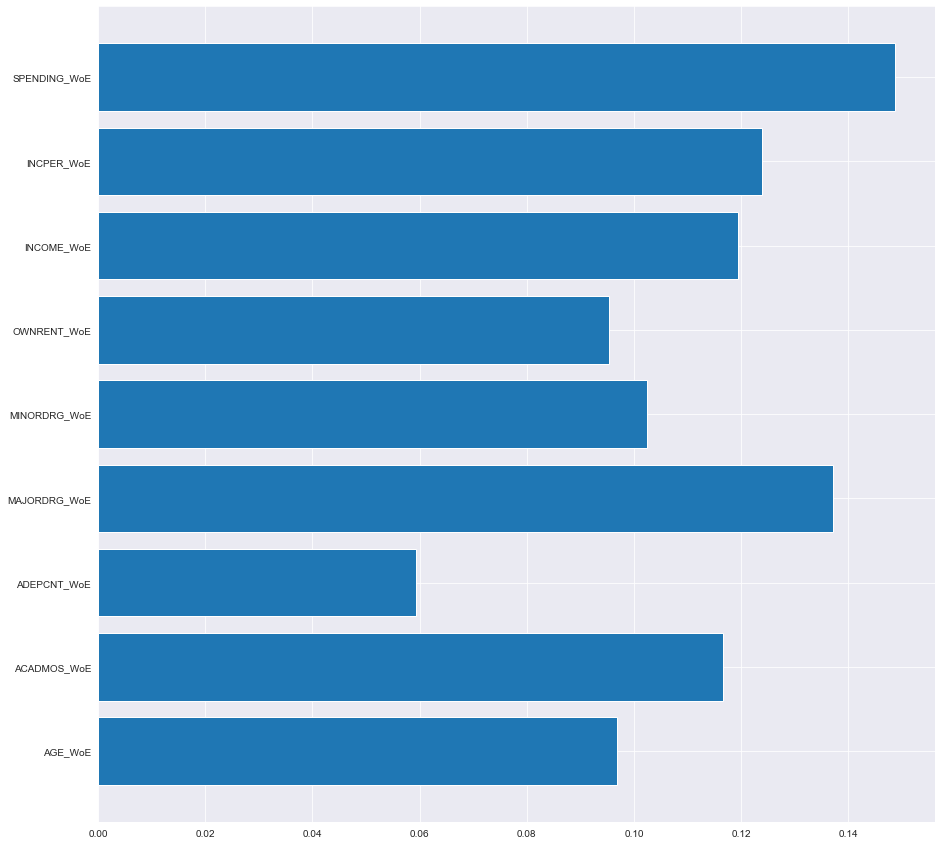

In [ ]:
imp_xgb
plt.barh(features_woe,imp_xgb)


For the best model (XGBoost), the most important variable in the probability assessment is the WoE variable describing the average monthly expenses from a credit card

<h1> Summary </h1>

Using the Logit and Probit models, an analysis of the impact and probability of the impact of individual variables on the probability of default occurring in the respondents was carried out. Probit estimated on the WoE variables, with the highest value of the Gini index, fared best from both models. For the purpose of prediction, 3 sets were used: raw data, data selected using the RFECV method with the use of a random forest, and the WoE set. Also in this case, the best values in the models were obtained on sets with WoE variables. In order to predict default, the XGBoost model was the best and the logistic regression was slightly worse. The selection and transformation of the data set have the greatest impact on the obtained results, rather than other factors, e.g. the selection of hyperparameters.